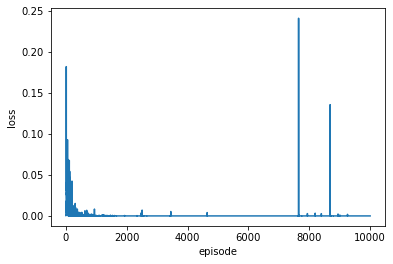

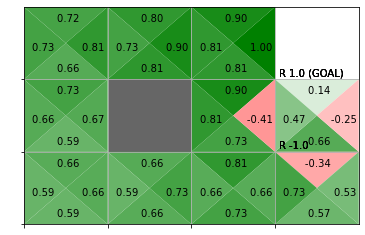

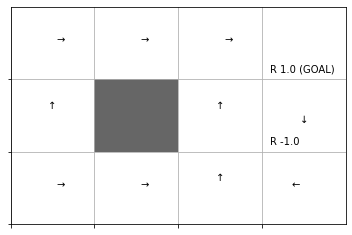

In [6]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L


# for importing the parent dirs
sys.path.append(r"C:\Users\kam_r\OneDrive\Desktop\Kamichan_R\Reinforcement Learning\source")


from common.gridworld import GridWorld


def one_hot(state):
    HEIGHT, WIDTH = 3, 4
    vec = np.zeros(HEIGHT * WIDTH, dtype=np.float32)
    y, x = state
    idx = WIDTH * y + x
    vec[idx] = 1.0
    return vec[np.newaxis, :]


class QNet(Model):
    def __init__(self):
        super().__init__()
        self.l1 = L.Linear(100)  # hidden_size
        self.l2 = L.Linear(4)  # action_size

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x


class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.lr = 0.01
        self.epsilon = 0.1
        self.action_size = 4

        self.qnet = QNet()
        self.optimizer = optimizers.SGD(self.lr)
        self.optimizer.setup(self.qnet)

    def get_action(self, state_vec):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            qs = self.qnet(state_vec)
            return qs.data.argmax()

    def update(self, state, action, reward, next_state, done):
        if done:
            next_q = np.zeros(1)  # [0.]
        else:
            next_qs = self.qnet.forward(next_state)
            next_q = next_qs.max(axis=1)
            next_q.unchain()

        target = self.gamma * next_q + reward
        qs = self.qnet(state)
        q = qs[:, action]
        loss = F.mean_squared_error(target, q)

        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()

        return loss.data


env = GridWorld()
agent = QLearningAgent()

episodes = 10000
loss_history = []

for episode in range(episodes):
    state = env.reset()
    state = one_hot(state)
    total_loss, cnt = 0, 0
    done = False

    while not done:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        next_state = one_hot(next_state)

        # print(state, action, reward, next_state, done)
        loss = agent.update(state, action, reward, next_state, done)
        total_loss += loss
        cnt += 1
        state = next_state

    average_loss = total_loss / cnt
    loss_history.append(average_loss)

plt.xlabel('episode')
plt.ylabel('loss')
plt.plot(range(len(loss_history)), loss_history)
plt.show()

# visualize
Q = {}
for state in env.states():
    for action in env.action_space:
        q = agent.qnet(one_hot(state))[:, action]
        Q[state, action] = float(q.data)
env.render_q(Q)
